# STA 141B: Homework 5
Winter 2018

## Student Information

After the colons (in the same line) please write just your first name, last name, and the 9 digit student ID number below.

First Name:Zihao

Last Name: Chen

Student ID: 915490404

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements.  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ (20 pts) Which mobile food vendor(s) sells at the most locations?

Because I am not familiar with the law, I will simply consider each vendor only got one permit.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd


import geopandas as gpd         
import osmnx as ox              
import shapely.geometry as geom
import fiona

In [2]:
from sqlalchemy import create_engine
db = create_engine('sqlite:///sf_data.sqlite')

In [3]:
mobile_food_schedule=pd.read_sql_query('SELECT * FROM mobile_food_schedule',db)
mobile_food_schedule.head()

,locationid,permit,DayOfWeek,EndHour,StartHour
0,305727,11MFF-0040,Mo,15,10
1,305727,11MFF-0040,Tu,15,10
2,305727,11MFF-0040,We,15,10
3,305727,11MFF-0040,Th,15,10
4,305727,11MFF-0040,Fr,15,10


In [4]:
#get rid of the time variables and drop the duplicates permit-locationid pair. we get the following.
perm_loca=mobile_food_schedule[['permit','locationid']].drop_duplicates()
perm_loca.head()

,permit,locationid
0,11MFF-0040,305727
14,11MFF-0040,305735
28,11MFF-0070,321365
33,11MFF-0175,334914
44,11MFF-0177,338539


perm_loca.groupby('permit').count() to get how many location did the permit have

x.sort_values('locationid',ascending=False). to order the data by locationid and get the first

which is the answer of "Which mobile food vendor(s) sells at the most locations". but the answer is still not clear because it is the permit code, 

we need the name.

In [5]:
most=perm_loca.groupby('permit').count().sort_values('locationid',ascending=False).index[0]
most

'17MFF-0110'

In [6]:
#to get the company name of the permit holder, we need the table below.
mobile_food_permits=pd.read_sql_query('SELECT * FROM mobile_food_permits',db)
mobile_food_permits.head()

,permit,Status,Applicant,FacilityType,FoodItems,PriorPermit,Approved,Expiration
0,16MFF-0027,APPROVED,F & C Catering,Truck,Cold Truck: Hot/Cold Sandwiches: Water: Soda: ...,1,2016-03-09 12:00:00,2017-03-15 12:00:00
1,13MFF-0102,EXPIRED,Natan's Catering,Truck,Burgers: melts: hot dogs: burritos:sandwiches:...,1,2013-04-12 12:00:00,2014-03-15 12:00:00
2,16MFF-0069,APPROVED,Munch A Bunch,Truck,Cold Truck: packaged sandwiches: pitas: breakf...,1,2016-03-15 12:00:00,2017-03-15 12:00:00
3,16MFF-0051,APPROVED,Park's Catering,Truck,Cold Truck: Hamburger: cheeseburgers: hot dogs...,1,2016-03-15 12:00:00,2017-03-15 12:00:00
4,16MFF-0010,REQUESTED,Pipo's Grill,Truck,Tacos: Burritos: Hot Dogs: and Hamburgers,0,None,None


In [7]:
most_name=mobile_food_permits[mobile_food_permits['permit']==most]['Applicant'].tolist()
print("%s is the mobile food vendor(s) which sells at the most locations"%most_name[0])

May Catering is the mobile food vendor(s) which sells at the most locations


__Exercise 1.2.__ (40 pts) Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

__1 .Which parts of the city are the most and least expensive?__

According to the database, we got "Zillow rent and housing statistics dating back to 1996". After checking, the RegionName collumn is the zip code of the area so that we can get the price information by the zipcode. 

There are several collums about the Homes. According to the question, we only need the MedianSoldPricePerSqft_Allhomes collums which means I will use the sold price per sqft to figure out which zip code region is the most or least expensive.

In [8]:
zillow=pd.read_sql_query('SELECT * FROM zillow',db)
zillow['Date']=pd.to_datetime(zillow['Date'])  

Homes=zillow.dropna(subset=["MedianSoldPricePerSqft_AllHomes"])
#get the most recent price of these area of zipcode
Soldprice=Homes.groupby('RegionName').apply(lambda t: t[t.Date==t.Date.max()])[['RegionName','Date','MedianSoldPricePerSqft_AllHomes']]


#the top 5 expensive region
Soldprice.sort_values('MedianSoldPricePerSqft_AllHomes',ascending=False).head()

,,RegionName,Date,MedianSoldPricePerSqft_AllHomes
RegionName,,,,
94104,5488,94104,2007-10-01,1336.128581
94123,1663,94123,2016-05-01,1276.685200
94102,1383,94102,2015-06-01,1189.393939
94105,1672,94105,2016-05-01,1188.261200
94131,1690,94131,2016-06-01,1123.055600


In [9]:
#the top 5 cheapest region
Soldprice.sort_values('MedianSoldPricePerSqft_AllHomes',ascending=True).head()

,,RegionName,Date,MedianSoldPricePerSqft_AllHomes
RegionName,,,,
94124,1669,94124,2016-05-01,583.533173
94080,1678,94080,2016-06-01,628.616900
94132,1693,94132,2016-06-01,639.163277
94134,1667,94134,2016-05-01,650.256100
94112,1704,94112,2016-07-01,755.397000


In [10]:
zipcode = gpd.read_file("cb_2016_us_zcta510_500k/cb_2016_us_zcta510_500k.shp")
zipcode.head()

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry
0,21914,8600000US21914,21914,1924479,477175,"POLYGON ((-75.99444799999999 39.567742, -75.99..."
1,01001,8600000US01001,01001,29731610,2118827,"POLYGON ((-72.667677 42.045022, -72.657715 42...."
2,34736,8600000US34736,34736,322808220,78588518,"(POLYGON ((-81.806163 28.568643, -81.801577999..."
3,46151,8600000US46151,46151,530632048,9804480,"(POLYGON ((-86.398562 39.320829, -86.398125999..."
4,48039,8600000US48039,48039,59592687,4845242,"POLYGON ((-82.61060000000001 42.724669, -82.51..."


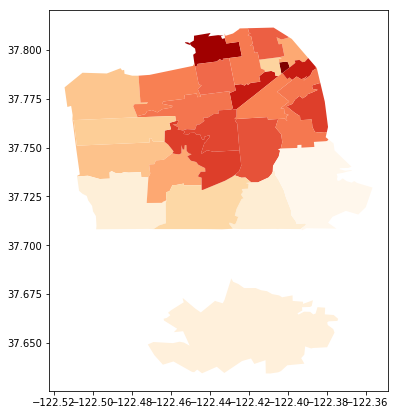

In [11]:
zipcode['ZCTA5CE10']=pd.to_numeric(zipcode['ZCTA5CE10'])
zipcode_price=pd.merge(zipcode,Soldprice,how='right',left_on='ZCTA5CE10',right_on='RegionName')
zipcode_price.plot(column='MedianSoldPricePerSqft_AllHomes',cmap='OrRd',figsize = (7, 7))

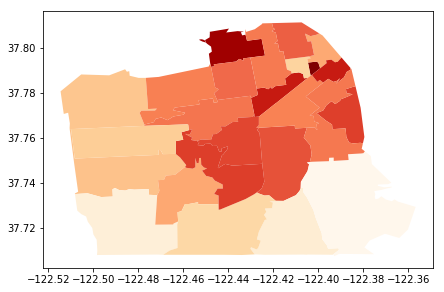

In [12]:
#The plot above shows the sold price of the region, there is some mistaken region. I will get rid of it to show only San Francisco.
zipcode_price_san=zipcode_price[[x.bounds[1]>37.7 for x in zipcode_price["geometry"]]]
zipcode_price_san.plot(column='MedianSoldPricePerSqft_AllHomes',cmap='OrRd',figsize = (7, 7))

The darker the color is, the more expensive the region is.

Further study is using the ZriPerSqft_AllHomes as the price. ZRI is Zillow Rent Index which is the index telling us about the rent price.

In [13]:
Homes2=zillow.dropna(subset=["PriceToRentRatio_AllHomes"])
#get the most recent rent price of these area of zipcode
Rentprice=Homes2.groupby('RegionName').apply(lambda t: t[t.Date==t.Date.max()])[['RegionName','Date','PriceToRentRatio_AllHomes']]
#the top 5 expensive region
Rentprice.sort_values('PriceToRentRatio_AllHomes',ascending=False).head()

,,RegionName,Date,PriceToRentRatio_AllHomes
RegionName,,,,
94123,1863,94123,2017-01-01,25.49
94127,1870,94127,2017-01-01,25.17
94121,1857,94121,2017-01-01,25.14
94122,1852,94122,2017-01-01,23.97
94114,1860,94114,2017-01-01,23.93


In [14]:
#the top 5 cheapest region
Rentprice.sort_values('PriceToRentRatio_AllHomes',ascending=True).head()

,,RegionName,Date,PriceToRentRatio_AllHomes
RegionName,,,,
94124,1869,94124,2017-01-01,16.94
94134,1867,94134,2017-01-01,17.89
94102,1858,94102,2017-01-01,18.20
94103,1864,94103,2017-01-01,18.80
94112,1854,94112,2017-01-01,19.06


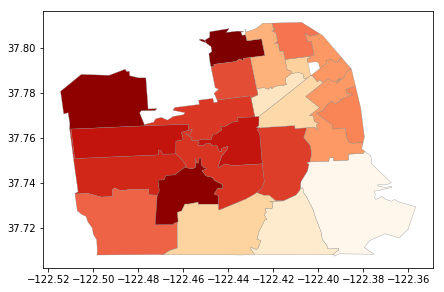

In [15]:
zipcode_price2=pd.merge(zipcode,Rentprice,how='right',left_on='ZCTA5CE10',right_on='RegionName')
zipcode_price2_san=zipcode_price2[[x.bounds[1]>37.7 for x in zipcode_price2["geometry"]]]
zipcode_price2_san.plot(column='PriceToRentRatio_AllHomes',
                       cmap='OrRd',figsize = (7, 7),edgecolor = "gray",linewidth = 0.3)

As show above, the plot changes a lots. It means that the most expensive to sell is not the most expensive to rent.

__2.Which parts of the city are the most dangerous (and at what times)?__

According to the database, we got crime table which is described as "Crime reports dating back to 2010.". After checking it, the table contain records of crime. I consider each crime is the same (I am not able to figure out which report is more serious than the other.). In the database, we got lots of information about the records and i will use them to plot two different kinds of graph.

In [16]:
crime=pd.read_sql_query('SELECT * FROM crime LIMIT 5',db)
crime

,IncidntNum,Category,Descript,DayOfWeek,Datetime,PdDistrict,Resolution,Address,Lon,Lat
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,2015-01-19 14:00:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,2015-01-27 19:00:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469


As shown above, all we need is the PdDistrict and count how many times each Police Department District appears.

In [17]:
crime = pd.read_sql_query('SELECT PdDistrict,COUNT(*) FROM crime GROUP BY PdDistrict',db)
crime = crime.sort_values('COUNT(*)',ascending=False) # order the data to make the analysis code easier
crime

,PdDistrict,COUNT(*)
8,SOUTHERN,196178
4,MISSION,136216
5,NORTHERN,124365
2,CENTRAL,109242
1,BAYVIEW,101655
3,INGLESIDE,89044
10,TENDERLOIN,84009
9,TARAVAL,75459
6,PARK,60974
7,RICHMOND,56258


In [18]:
print('the Police Department District of %s is the most busy one which means it is the most dangrous part of SF.'
      %crime.sort_values('COUNT(*)',ascending=False).iloc[0,0].lower())

the Police Department District of southern is the most busy one which means it is the most dangrous part of SF.


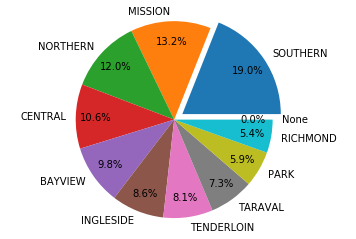

In [19]:
#here is the pie plot to show the percentage of the data.
#the largest part is seperate from the pie plot to make an emphasis.
import matplotlib.pyplot as plt
explode=[0 for i in range(len(crime))]
explode[0]=0.1
explode

plt.pie(crime.iloc[:,1],labels=crime.iloc[:,0],explode=explode,pctdistance = 0.8,autopct = '%3.1f%%')
plt.axis('equal')
plt.show()

In [20]:
# it take too long to plot all the point, so that i limit the number and randomly take the records
crime=pd.read_sql_query('SELECT * FROM crime ORDER BY RANDOM() LIMIT 10000',db)
lonlat = [geom.Point(x) for x in zip(crime.Lon, crime.Lat)]
crime = gpd.GeoDataFrame(crime,geometry = lonlat)

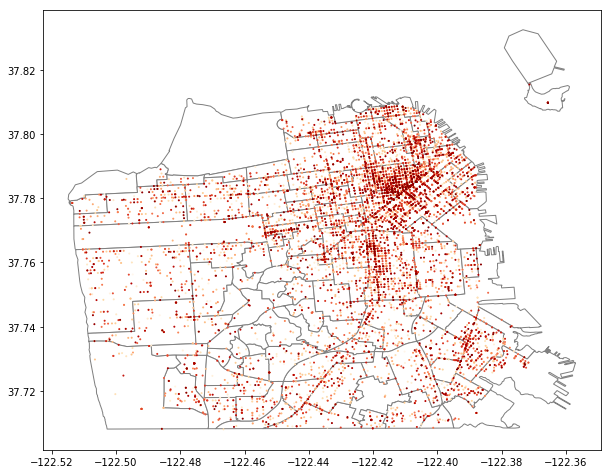

In [21]:
district = gpd.read_file("SF Find Neighborhoods/geo_export_bd0e5c9e-c6fb-4e8a-9e99-8508c24403c4.shp")
ax = district.plot(color = "white",edgecolor = "gray",figsize = (10, 10))
crime.plot(ax = ax,markersize = 1,cmap='OrRd')

The second plot is much straightforward. The more focus the point is, the more dangrous it is.

__3.Are noise complaints and mobile food vendors related?__

About the noise complaints, we got the data from table "noise". 

Merging the data with Shapefiles for San Francisco Neighborhoods, here is the map of complaints. 

The darker it is, the more noise complaint it got.

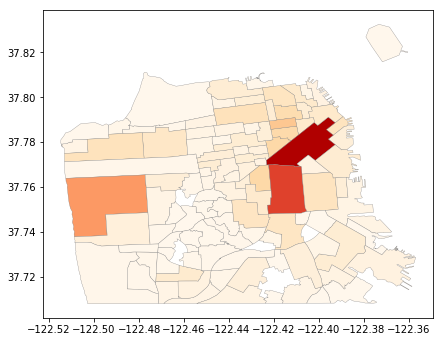

In [22]:
noise=pd.read_sql_query('SELECT Neighborhood,COUNT(*) FROM noise GROUP BY Neighborhood',db)
noise_neigh=pd.merge(district,noise,how='right',left_on='name',right_on='Neighborhood')
noise_neigh.plot(column='COUNT(*)',cmap='OrRd',figsize = (7, 7),edgecolor = "gray",linewidth = 0.3)

Then, we plot dots of the vendors in it

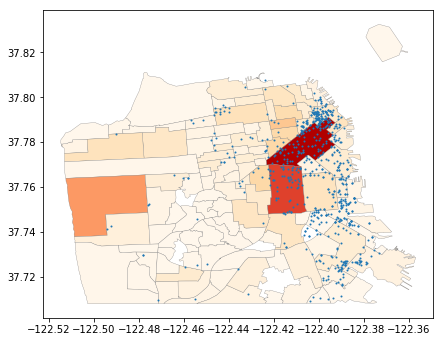

In [23]:
mobile_food_locations=pd.read_sql_query('SELECT * FROM mobile_food_locations',db)
#there are many vendor did not have data about the latitude and longitude
mobile_food_locations=mobile_food_locations[mobile_food_locations.Latitude>0]
lonlat = [geom.Point(x) for x in zip(mobile_food_locations.Longitude, mobile_food_locations.Latitude)]
vendor_location = gpd.GeoDataFrame(mobile_food_locations,geometry = lonlat)

ax=noise_neigh.plot(column='COUNT(*)',cmap='OrRd',figsize = (7, 7),edgecolor = "gray",linewidth = 0.3)
vendor_location.plot(ax = ax,markersize = 1)

As we can see above, There are so many dots on the light space. There is a concentrated area in the upper right corner which is also with light color. The relation between noise and vender may be weak.

On the other hand, although the darkest area have lots of dots, the third darkest area did not have any dot in it. It is also tells us the relation between noise and vender is weak.

__4.What are the best times and places to find food trucks?__

The first idea comes in my head is that i can make a dynamic map to show where are the vendors in the specific time . It is not in class but i found some tool to do so https://plot.ly/products/dash/

According to the meterial in the class, I think i can seperate this question into two parts.

1. What are the best times to find food trucks?

2. Where are the places to find food trucks in the best time?

And I will also define a function to act like a dynamic map.

In [24]:
food = pd.read_sql_query('SELECT * FROM mobile_food_locations AS a, mobile_food_schedule AS b WHERE a.locationid=b.locationid',db)
food=food[food.Latitude>0] #get rid of those vendor we cannot find in the map.
lonlat = [geom.Point(x) for x in zip(food.Longitude, food.Latitude)]
food = gpd.GeoDataFrame(food,geometry = lonlat)
food.head()

,locationid,LocationDescription,Address,Latitude,Longitude,locationid,permit,DayOfWeek,EndHour,StartHour,geometry
0,762182,TOWNSEND ST: 05TH ST to 06TH ST (400 - 499),444 TOWNSEND ST,37.774871,-122.398532,762182,16MFF-0027,Fr,11,10,POINT (-122.398531708276 37.7748713162388)
1,762182,TOWNSEND ST: 05TH ST to 06TH ST (400 - 499),444 TOWNSEND ST,37.774871,-122.398532,762182,16MFF-0027,Mo,11,10,POINT (-122.398531708276 37.7748713162388)
2,762182,TOWNSEND ST: 05TH ST to 06TH ST (400 - 499),444 TOWNSEND ST,37.774871,-122.398532,762182,16MFF-0027,Th,11,10,POINT (-122.398531708276 37.7748713162388)
3,762182,TOWNSEND ST: 05TH ST to 06TH ST (400 - 499),444 TOWNSEND ST,37.774871,-122.398532,762182,16MFF-0027,Tu,11,10,POINT (-122.398531708276 37.7748713162388)
4,762182,TOWNSEND ST: 05TH ST to 06TH ST (400 - 499),444 TOWNSEND ST,37.774871,-122.398532,762182,16MFF-0027,We,11,10,POINT (-122.398531708276 37.7748713162388)


In [25]:
import numpy as np
day=['Mo','Tu','We','Th','Fr','Sa','Su']
time = pd.DataFrame(np.zeros([24,7]))
time.columns=day


for i in range(0,24):
    for j in range(0,7):
        time.iloc[i,j]=pd.read_sql_query("SELECT COUNT(*) FROM mobile_food_schedule WHERE DayOfWeek='"+day[j]+
                                         "' AND EndHour>"+str(i)+" AND StartHour<="+str(i),db).iloc[0,0]
# the table below shows how many vendors are there for each period of the week
time

,Mo,Tu,We,Th,Fr,Sa,Su
0,68.0,63.0,62.0,64.0,63.0,3.0,3.0
1,68.0,63.0,62.0,64.0,63.0,3.0,3.0
2,68.0,63.0,62.0,64.0,63.0,3.0,3.0
3,68.0,63.0,62.0,63.0,62.0,2.0,3.0
4,69.0,64.0,63.0,64.0,63.0,2.0,3.0
5,74.0,67.0,66.0,67.0,66.0,2.0,3.0
6,137.0,112.0,113.0,111.0,109.0,26.0,24.0
7,157.0,149.0,149.0,146.0,144.0,35.0,32.0
8,208.0,188.0,189.0,183.0,181.0,49.0,41.0
9,264.0,252.0,254.0,244.0,244.0,65.0,71.0


Here is the best time for each day to find food. 

In [26]:
time.idxmax()

Mo    10
Tu    10
We    10
Th    10
Fr    10
Sa    10
Su    10
dtype: int64

In [27]:
time.iloc[10,:].idxmax()

'Mo'

As shown above,10 O'clock is the best time to find food trucks everyday. 10 o'clock Monday is the best time to find food trucks in the whole week.

It is still unclear where is the best place to find food trucks.

The following is the function i mentioned before, it will return a vendor map of a certain day and a certain hour.

P.S. Some food truck in the database did not have the coordinate so that the number of points showed in the map will not fit the table above.

In [28]:
def fun(dayofweek,hour):
    """
    Enter which day of week and which hour, it will show you a map of the vendor in  San Francisco
    
    Arg:
    dayofweek: like "Monday"
    hour: like "13", it is in the format of 24 hours
    """
    day = str(dayofweek)[0:2].lower()
    food.DayOfWeek2=food.DayOfWeek.str.lower()# to avoid lower case problem
    data = food[(food.DayOfWeek2==day )& (food.EndHour>hour) & (food.StartHour<=hour)]
    #district = gpd.read_file("SF Find Neighborhoods/geo_export_bd0e5c9e-c6fb-4e8a-9e99-8508c24403c4.shp")
    ax = district.plot(color = "white",edgecolor = "gray",figsize = (10, 10))
    if len(data)!=0:
        data.plot(ax = ax,markersize = 1,)
    else: print('No vendor avaliable in the map in this time')

As time issue is solved, here i will show a map of Friday 10 o'clock to imply the best place to go.

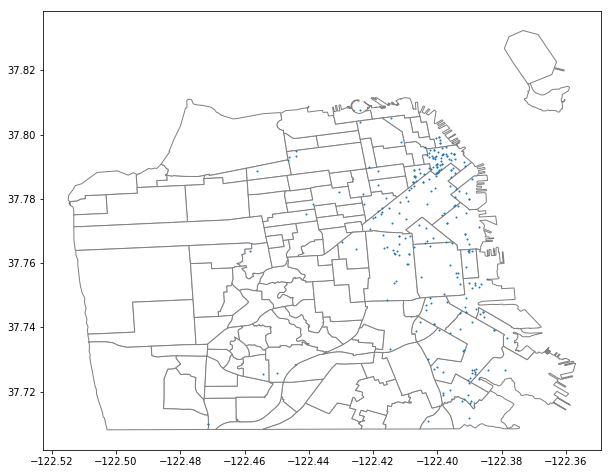

In [29]:
fun("Wednesday",10)

No vendor avaliable in the map in this time


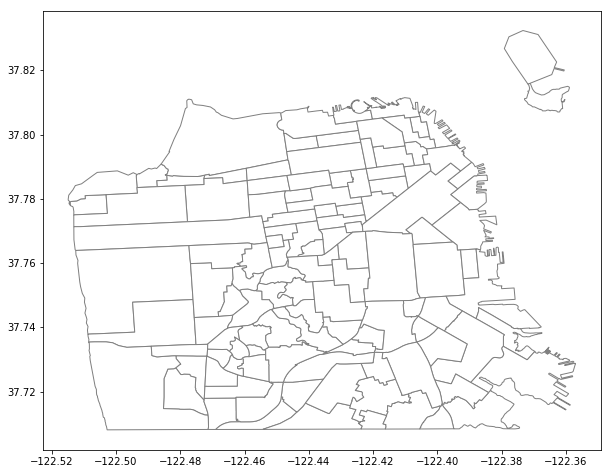

In [34]:
#No vendor avaliable, this is just for function debugging

fun("Monday",23)

__5.Is there a relationship between housing prices and any of the other tables?__

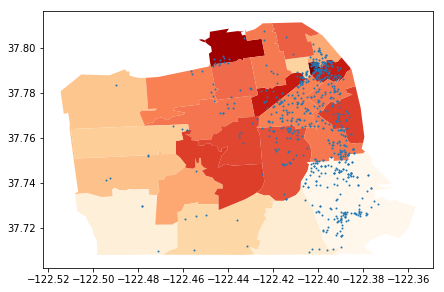

In [31]:
ax=zipcode_price_san.plot(column='MedianSoldPricePerSqft_AllHomes',cmap='OrRd',figsize = (7, 7))
vendor_location.plot(ax = ax,markersize = 1)